# Multimode QSM
This is the main notebook interface for QSM data collection

First start the image server by running "sudo python Server.py" in the /home/photon/code/Camserver folder:

In [24]:
%matplotlib inline 

In [25]:
from pqoqsm import *

In [26]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

In [27]:
""" Set up lists to hold the analysis output, only call this cell to clear the data before a new round of collection """
output = []

In [28]:
# Create the ZMQ camera connection:
from pylonZmq import *

In [29]:
from qfigures import *

### Setup and test the arduino-controlled shutter

In [30]:
from arduinoshutter import *

In [31]:
sigClose()

In [32]:
sigOpen()

## Use these cells to check acquisition etc, and collect BG

In [33]:
request_images(client,N=3)
background_shots = open_images()

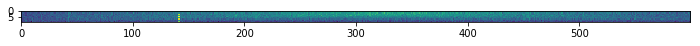

In [34]:
plt.imshow(background_shots[:,:,-1])

In [35]:
# take the last shot as the background
# this a workaround to account for the extra signal that comes in on the first shot
# TODO: figure this out.
background = background_shots[:,:,-1]  
background = background[:,:,np.newaxis]

In [36]:
request_images(client,N=5)
data = open_images()

In [37]:
corrected = data - background

In [38]:
# calculate power in Watts
corrected.sum() * 2.54704992e-19 / (6e-3 * 5) 

1.5848933225536002e-12

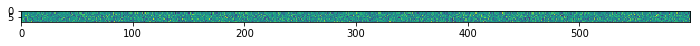

In [39]:
plt.imshow(corrected[:,:,-1])

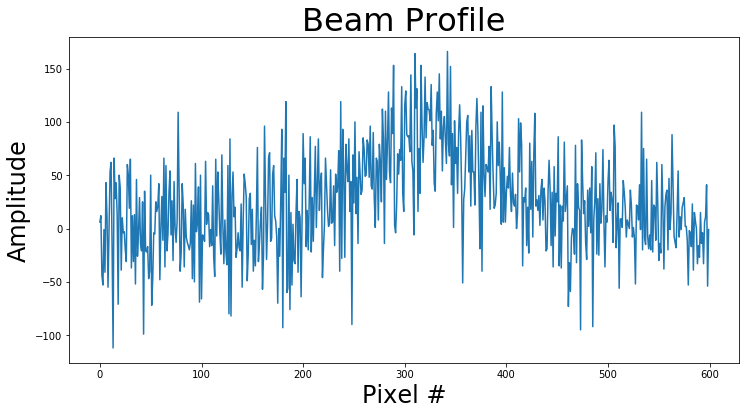

In [40]:
plt.plot(corrected[5,:,0])
#plt.plot(background[5,:,0])
plt.title("Beam Profile", fontsize=32)
plt.xlabel("Pixel #", fontsize=24)
plt.ylabel("Amplitude",fontsize=24)

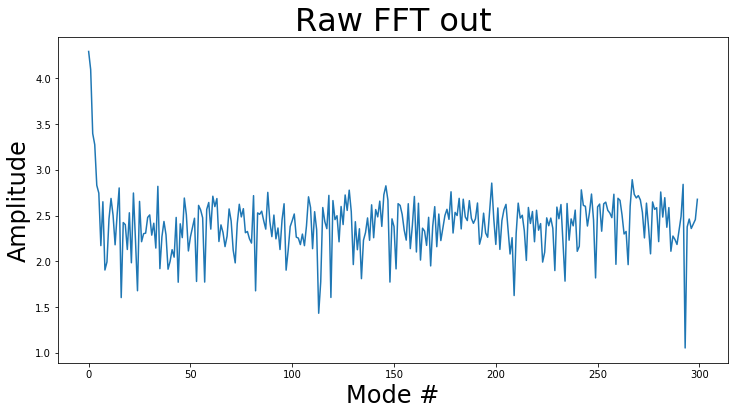

In [41]:
plt.plot(np.log10(abs(fft( np.average(corrected[:,:,0],axis = 0)  )[0:300] )))
plt.title("Raw FFT out", fontsize=32)
plt.xlabel("Mode #", fontsize=24)
plt.ylabel("Amplitude",fontsize=24)

# This is the one-cell version:
Starts with a vacuum collection, then does a full data set.

In [50]:
#Interspersed vacuum and data runs:

frames = 50  # frames to collect (this is sent to th e ZMQ server)
rounds = 10 # rounds of data (total shots is N*M)

dataOut = np.empty([600,frames,rounds],dtype=complex)
vacOut = np.empty([600,frames,rounds],dtype=complex)
VacCorrected = np.empty([600,frames,rounds],dtype=complex)
#BGcorrectedArray = np.empty([10,600,frames,rounds],dtype=complex) # delete this later
ncount = np.empty([frames,rounds])
for r in range(rounds): # take M rounds:
    print "vacuum round: %i" % (r+1)
    time.sleep(2)
    sigClose()
    time.sleep(2)
    request_images(client,frames+1) # request one extra frame to use at beginning to clean CCD
    vac = open_images()
    if frames != vac.shape[2] - 1: # account for extra frame
        print "Warning, frame shape mismatch"
    ydim = vac.shape[0]
    xdim = vac.shape[1]
    
    for f in range (0, frames):

        
        BGcorrected_vac = vac[:,:,f+1] - background[:,:,0] # could probably speed this up?
        # skip first frame to clean CCD
        
        # vertical sum over all rows, then fftshift, then fft:
        vacOut[:,f,r] = fft( fftshift( BGcorrected_vac.sum(axis = 0) ) )
        
    vacFFT = np.average(vacOut[:,:,r],axis=1)
    
    print "data round: %i" % (r+1)
    time.sleep(2)
    sigOpen()
    time.sleep(2)
    
    request_images(client,frames+1) # request one extra frame to use at beginning to clean CCD
    data = open_images()
    if frames != data.shape[2] - 1: # account for extra frame
        print "Warning, frame shape mismatch"
    ydim = data.shape[0]
    xdim = data.shape[1]
    for f in range (0, frames): 
 
        BGcorrected = data[:,:,f+1] - background[:,:,0] # could probably speed this up?
        #BGcorrectedArray[:,:,f,r] = BGcorrected # use this to store raw data for debugging
        # Track the total power (i.e. sum all photons detected)
        ncount[f,r] = BGcorrected.sum()
    
        # vertical sum over middle 10 rows, then fftshift, then fft:
        dataOut[:,f,r] = fft( fftshift( BGcorrected.sum(axis = 0) ) )
    
    VacCorrected[:,:,r] = dataOut[:,:,r] - vacFFT.reshape(600,1)

print "Finished data"
saveRaw(VacCorrected,ncount)


vacuum round: 1
data round: 1
vacuum round: 2
data round: 2
vacuum round: 3
data round: 3
vacuum round: 4
data round: 4
vacuum round: 5
data round: 5
vacuum round: 6
data round: 6
vacuum round: 7
data round: 7
vacuum round: 8
data round: 8
vacuum round: 9
data round: 9
vacuum round: 10
data round: 10
Finished data
21-15-46_raw


## Log data filenames at this point!

(1000000.0, 300000000.0)

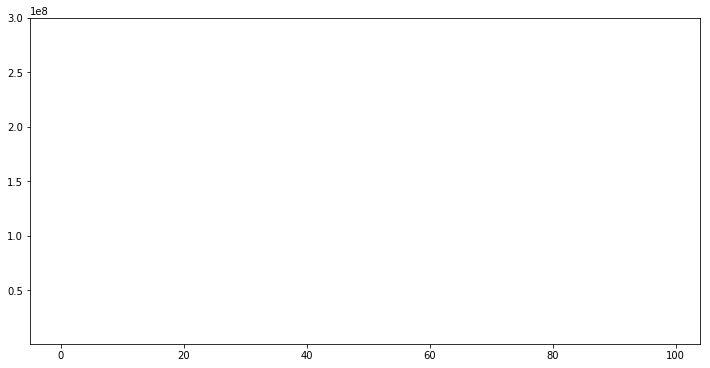

In [52]:
# This should be constant, no big drops or peaks. It is basically a measure of the LO power vs time.
plt.plot(ncount.flatten('F')[0:100],"o-")
plt.ylim([1e6,3e8])

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


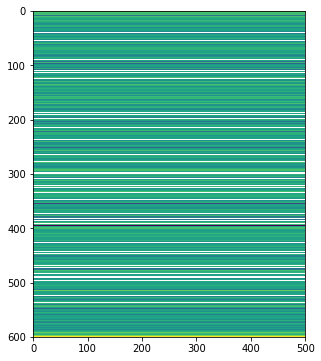

In [53]:
# Look at structure in the VacCorrected array vs. time
# Should be quiet except for where the signal is. Expect some peaks at the top and bottom edges (i.e. near DC)
plt.imshow(np.log10(abs( VacCorrected.reshape(600,rounds*frames) )))

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


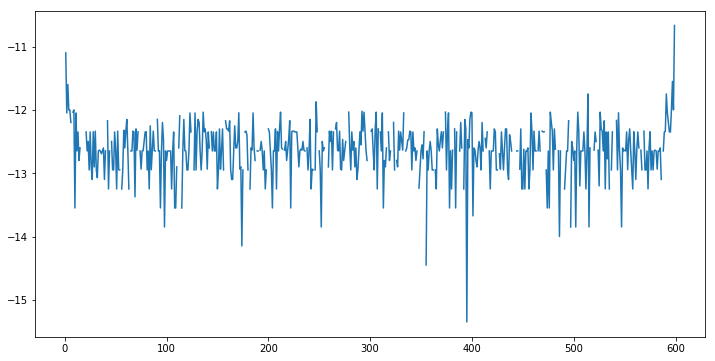

In [54]:
# full FFT output averaged for the data set
# needs to be quite flat above p = 200
plt.plot( np.log10(abs((np.average(VacCorrected,axis=(1,2)))) ))

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


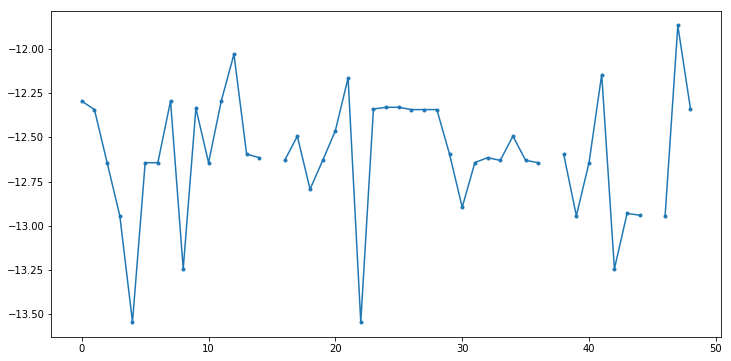

In [55]:
# look near the mode of interest (only useful for the strong-signal data)
plt.plot( np.log10(abs((np.average(VacCorrected,axis=(1,2)))) )[200:250],".-")

In [56]:
selectedMode = 280
output = (np.sqrt(2.0/ncount) * VacCorrected[selectedMode,:,:]).flatten('F')  
# Choose the mode to analyze, with n_t scaling

# output = VacCorrected[selectedMode,:,:].flatten()  # Choose the mode to analyze

Average amplitude: 0.000000


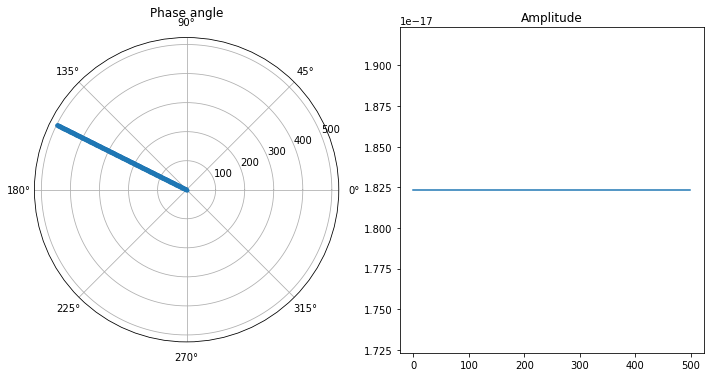

In [57]:
# Look at the average amplitude and a plot of phase angle and amplitude vs. shot number:
plt.subplot(121, polar=True)
plt.plot(angle(output),np.arange(len(output)),".-")
plt.title("Phase angle")
plt.subplot(122)
#plt.ylim(0,20)
plt.plot(abs(output))
plt.title("Amplitude")
print "Average amplitude: %f" % np.average(abs(output))

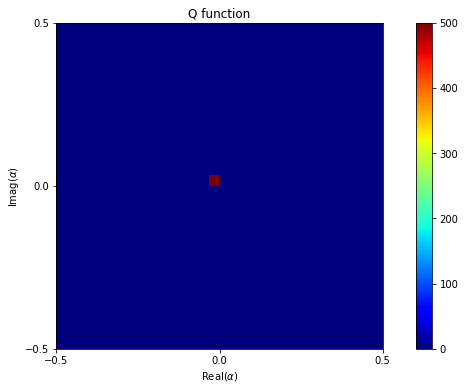

In [58]:
qfig = Qfunc.qfuncimage(output,30,0)

In [59]:
saveQfig(qfig,output)

19-35-46


In [60]:
np.save("10_06_data", output)

# Use the following for shot noise measurement

Note, this is wrong, we need to create this plot for the mode we analyze. In other words, go through more of the analysis and plot var(Kp) vs mean(Kp) for a specific mode. Can modify this code!

In [124]:
sys.path.append('/home/photon/code/Instruments')
import instrument
import time

In [127]:
rigolDG = instrument.RigolDG("/dev/usbtmc0")

Rigol Technologies,DG4102,DG4B151400125,00.01.04



In [337]:
datapoints = 12
means = numpy.zeros((10,600,datapoints))
variances = numpy.zeros((10,600,datapoints))
powers = numpy.linspace(1,5,datapoints)
#print powers
shot = 0
for lo_power in powers:
    command = ":VOLT:HIGH %s" % lo_power
    #print command
    rigolDG.write(command)
    time.sleep(2)
    request_images(client,N=100)
    data = open_images()
    #pylab.imshow(data[:,:,50])
    #pylab.show()
    print "Collected shot number %g" % (shot)
    #summed = data.sum(axis=0)
    means[:,:,shot] = data.mean(axis=2)
    variances[:,:,shot] = data.var(axis=2)
    #pylab.imshow(variances[:,:,shot])
    #pylab.show()
    shot+=1
    
print "Finished"

I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 0
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 1
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 2
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 3
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 4
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 5
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 6
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 7
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 8
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 9
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 10
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 11
Finished


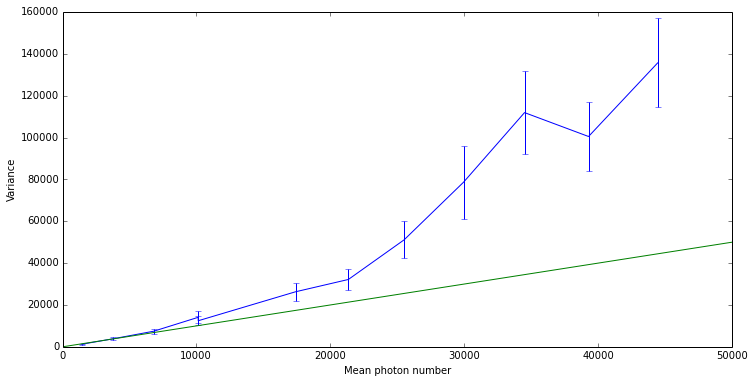

In [338]:
submeans = means[:,250:350,:]
subvars = variances[:,250:350,:]
x = submeans.mean(axis=(0,1))
y = subvars.mean(axis=(0,1))
yerr = subvars.std(axis=(0,1))
pylab.errorbar(x,y,yerr=yerr)
pylab.plot(numpy.arange(50000),numpy.arange(50000))
pylab.xlabel("Mean photon number")
pylab.ylabel("Variance")

In [214]:
from scipy import stats

In [339]:
slope, intercept, r_value, p_value, std_err = stats.linregress(submeans.flatten('F'),subvars.flatten('F'))
print slope
print std_err

3.17620871733
0.00943766085919


# Use the following to verify SNR

In [90]:
request_images(client,N=5)

I: Sending (5)


In [91]:
blocked = open_images()

I: Server replied OK: (10, 600, 5)


In [239]:
request_images(client,N=4)

I: Sending (4)


In [240]:
unblocked = open_images()

I: Server replied OK: (10, 600, 4)


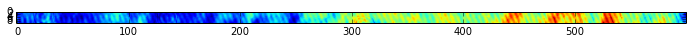

In [241]:
pylab.imshow(unblocked[:,:,:].mean(axis=2))

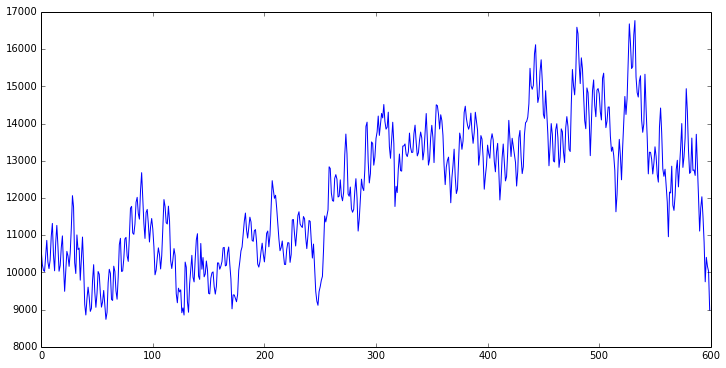

In [245]:
pylab.plot(unblocked[5,:,:].mean(axis=1))

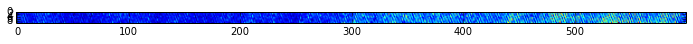

In [98]:
pylab.imshow(unblocked[:,:,:].var(axis=2))

In [104]:
snr = (unblocked-background).var(axis=2) / (blocked-background).var(axis=2)

In [105]:
snr.mean()

992.96047592928085

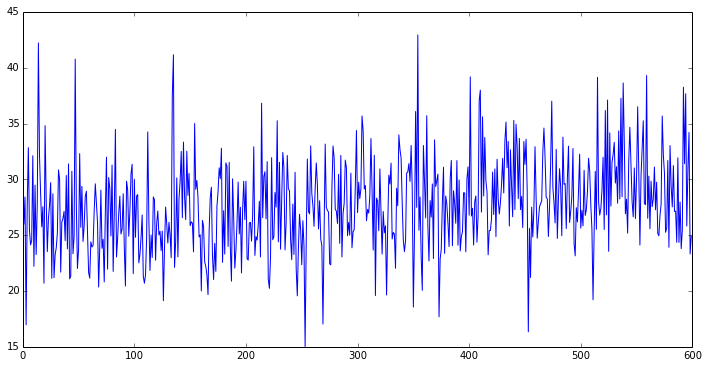

In [106]:
pylab.plot(10*np.log10(snr[5,:]))

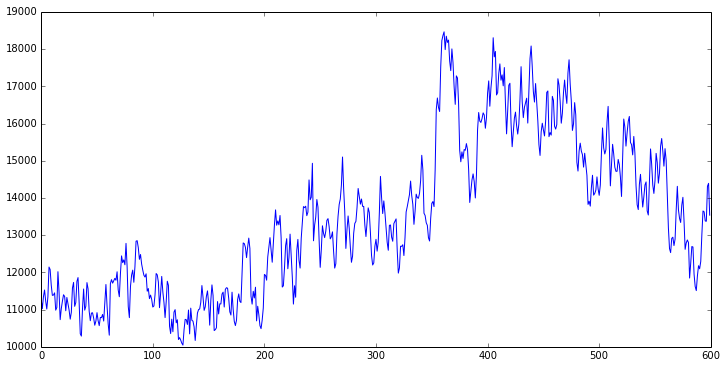

In [35]:
pylab.plot((unblocked-background)[5,:,0])